# Simple Regression

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from matplotlib import cm

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from macest.regression import models as reg_mod
from macest.regression import plots as reg_plot


In [3]:
sns.set_style('darkgrid')
sns.set_context('notebook')

### We simulate some data and split it into 4 sections
### The noise is not homoskedastic across the parameter space, half way through the data the noise decreases by a factor of 10

In [4]:
X = np.linspace(0,1,10**3)
y = np.zeros(10**3)
y[0:500] = X[0:500]*abs(np.sin(2 *X[0:500])) + np.random.normal(0 , 1 , len(X[0:500]))
y[500:] = X[500:]*abs(np.sin(2 *X[500:])) + np.random.normal(0 , 0.1 , len(X[500:]))

In [5]:
X_pp_train, X_conf_train, y_pp_train, y_conf_train  = train_test_split(X,
                                                                       y,
                                                                       test_size=0.66,
                                                                       random_state=0)

X_conf_train, X_cal, y_conf_train, y_cal = train_test_split(X_conf_train, y_conf_train,
                                                            test_size=0.5, random_state=1)
X_cal, X_test, y_cal,  y_test, =  train_test_split(X_cal, y_cal, test_size=0.5, random_state=1)

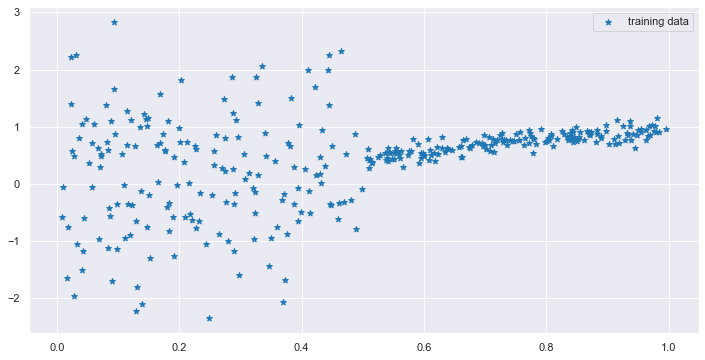

In [6]:
plt.figure(figsize = (12,6))
# plt.plot(X,y, label = 'true')
plt.scatter(X_pp_train,y_pp_train, marker = '*', label = 'training data')
plt.legend()

In [7]:
point_pred_model = LinearRegression()
point_pred_model.fit(X_pp_train[:,None], y_pp_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [8]:
point_pred_model.score(X_test[:,None], y_test)

0.035960050836218116

### let's plot the learnt model

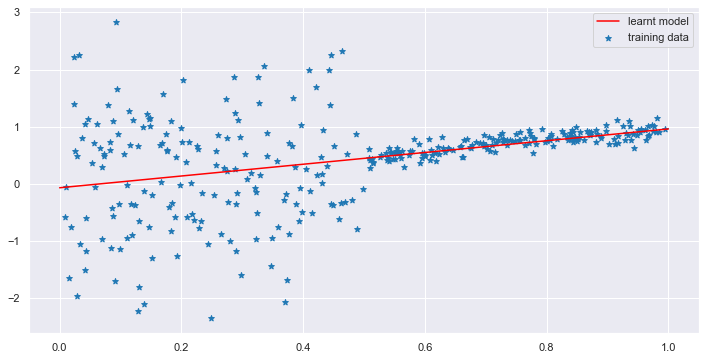

In [9]:
plt.figure(figsize = (12,6))
plt.scatter(X_pp_train,y_pp_train, marker = '*', label = 'training data')
plt.plot(X, point_pred_model.predict(X[:,None]), color ='r', label = 'learnt model')
plt.legend()

### Let's initialise the confidence model, with random alpha, beta and k

In [10]:
preds = point_pred_model.predict(X_conf_train[:,None])
train_error = y_conf_train - preds
test_error = abs(preds - y_conf_train)
y_conf_train_var = np.var(train_error)

In [11]:
macest_model = reg_mod.ModelWithPredictionInterval(point_pred_model,
                                                 X_conf_train[:,None],
                                                 test_error,)

In [12]:
macest_model.fit(X_cal[:,None],
               y_cal)

### Test how well calibrated our data is using unseen test data

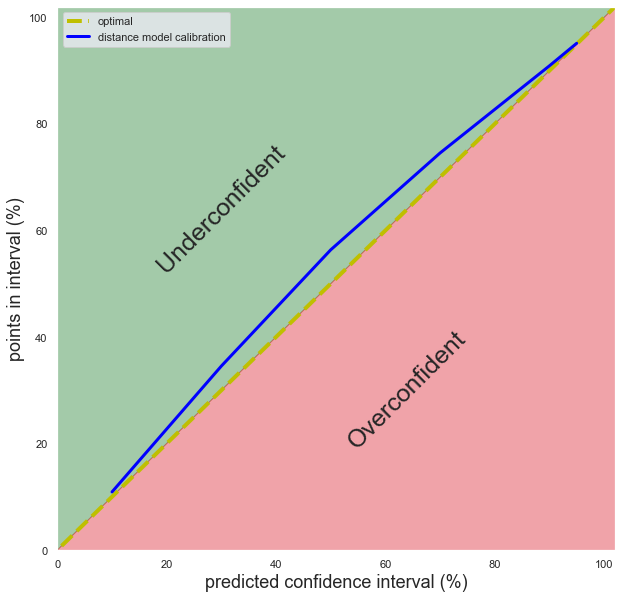

In [13]:
reg_plot.plot_calibration(macest_model, X_test[:,None], y_test)

### Let's plot the regression plots sorted by the prediction and then by the true value

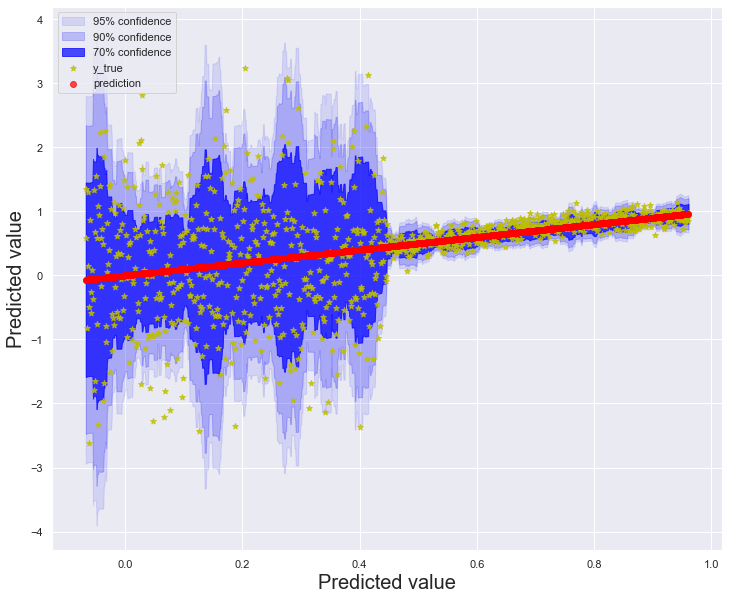

In [14]:
reg_plot.plot_predicted_vs_true(point_pred_model, macest_model,X[:,None], y)

### let's predict with an interval across the whole range of x, note that the confidence adapts locally to the variance found within the data

In [15]:
X = np.linspace(0,1,10**3)
test_dists = macest_model.sample_prediction(X[:,None], nsamples=10**4,)

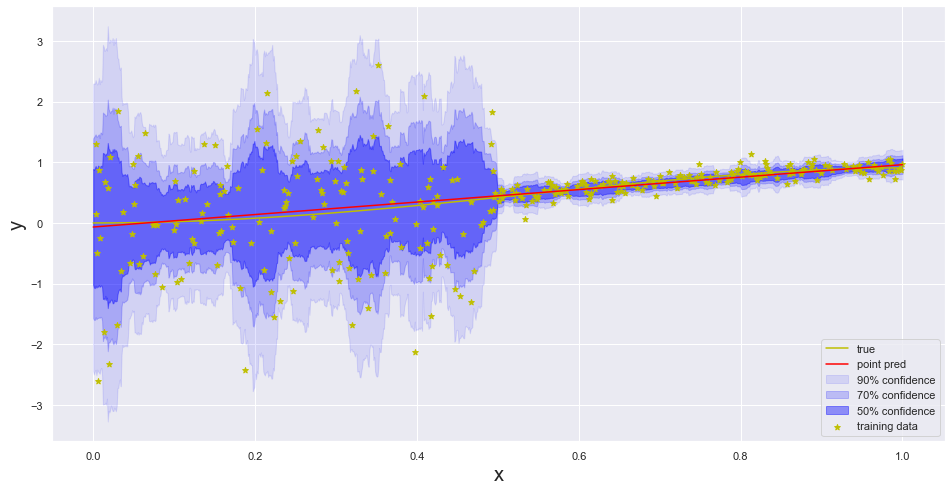

In [16]:
plt.figure(figsize = (16,8))

plt.fill_between(X, np.percentile(test_dists,95, axis=1), 
                 np.percentile(test_dists, 5, axis=1),color = 'b', alpha = 0.1,
                 label = '90% confidence'  )

plt.fill_between(X, np.percentile(test_dists,15, axis=1), 
                 np.percentile(test_dists, 85, axis=1),color = 'b', alpha = 0.2,
                 label = '70% confidence'  )

plt.fill_between(X, np.percentile(test_dists,25, axis=1), 
                 np.percentile(test_dists, 75, axis=1),color = 'b', alpha = 0.4,
                 label = '50% confidence'  )

plt.plot(X, X*abs(np.sin(2* X)), color = 'y', label = 'true' )
plt.plot(X,point_pred_model.predict(X[:,None]), color = 'r' , label = 'point pred')
plt.scatter(X_conf_train, y_conf_train, marker = '*', color = 'y', label = 'training data' )

plt.xlabel('x', fontsize = 20)
plt.ylabel('y', fontsize = 20)
plt.legend(loc = 'lower right')

### Let's try extrapolate, here we see that the epistemic uncertainty quickly dominates and the confidence interval becomes very large

In [17]:
X = np.linspace(0,2, 3 * 10**2)

In [18]:
y = X*abs(np.sin(2*X))
test_dists = macest_model.sample_prediction(X[:,None], nsamples=10**4,)

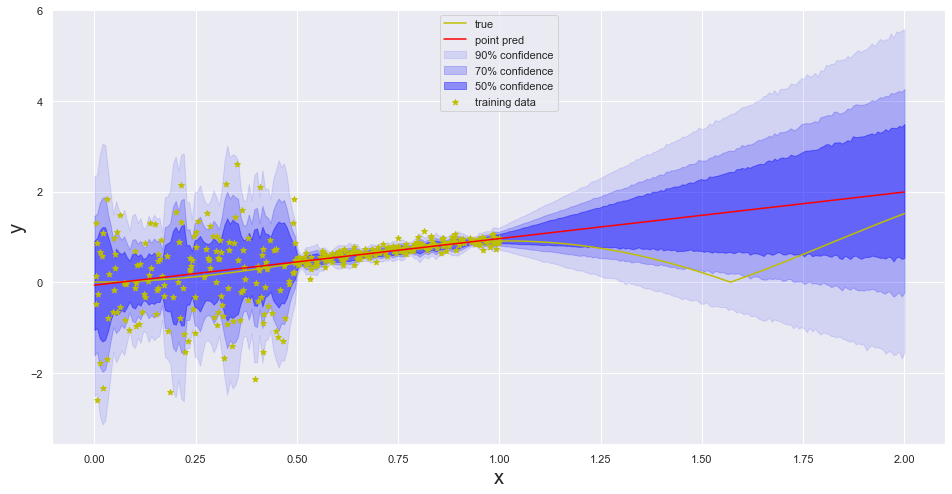

In [19]:
plt.figure(figsize = (16,8))

plt.fill_between(X, np.percentile(test_dists,95, axis=1), 
                 np.percentile(test_dists, 5, axis=1),color = 'b', alpha = 0.1,
                 label = '90% confidence'  )

plt.fill_between(X, np.percentile(test_dists,15, axis=1), 
                 np.percentile(test_dists, 85, axis=1),color = 'b', alpha = 0.2,
                 label = '70% confidence'  )

plt.fill_between(X, np.percentile(test_dists,25, axis=1), 
                 np.percentile(test_dists, 75, axis=1),color = 'b', alpha = 0.4,
                 label = '50% confidence'  )

plt.plot(X, y, color = 'y', label = 'true' )
plt.plot(X,point_pred_model.predict(X[:,None]), color = 'r' , label = 'point pred')
plt.scatter(X_conf_train, y_conf_train, marker = '*', color = 'y', label = 'training data' )


plt.xlabel('x', fontsize = 20)
plt.ylabel('y', fontsize = 20)
plt.legend(loc = 'upper center')